# Diffprivlib Experiment: Logistic Regression
---
<b>Author: A.Krauskopf<b><br>
<b>Last Update: 29 Oct 2024<b>

This notebook includes the iterative experiment code and figure creation focusing on both non-differentially private and differentially private instances of the logistic regression classification method. It depends upon the .csv files referenced to reside in the datasets subfolder in the same directory as this notebook. It also requires a figures subfolder for the resulting imagery to be saved to.

<b>Package Prerequisites:<b>
- pandas
- numpy
- matplotlib
- joblib
- tqdm
- sklearn
- diffprivlib

<b>Other Notebooks:<b>
- Gaussian Naiive Bayes (Diffprivlib Experiment-NB.ipynb)
- Random Forest (Diffprivlib Experiment-RF.ipynb)

### 1: Setup

In [109]:
# Import necessary packages
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import diffprivlib as dp
import time

In [110]:
# Setup dataframe to hold timing statistics
lr_runtime = pd.DataFrame(columns=['Setup', 'Validate', 'Baseline', 'Compare'], index=['Start Time', 'End Time', 'Runtime'])

# Capture start time
lr_runtime.loc['Start Time', 'Setup'] = time.time()

In [111]:
# Open and read the data into a dataframe
train = pd.read_csv('../datasets/fraudTrain_clean.csv', index_col=0)
test = pd.read_csv('../datasets/fraudTest_clean.csv', index_col=0)

# Split into dependent and independent variables
X_train = train.drop(['is_fraud'], axis=1)
y_train = train['is_fraud']

X_test = test.drop(['is_fraud'], axis=1)
y_test = test['is_fraud']

In [112]:
# Additional requirements specific to DP-LR

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Calculate the maximum L2 norm to prevent an error with DP-LR
total = pd.concat([train, test], ignore_index=True, sort=False)
X = total.drop(['is_fraud'], axis=1).values
X_scaled = scaler.fit_transform(X)
l2_norms = np.linalg.norm(X_scaled, axis=1)
data_norm = np.max(l2_norms)

lr_runtime.loc['End Time', 'Setup'] = time.time()

### 2: Verify DP(ε =∞) = non-private scikit learn

In [113]:
lr_runtime.loc['Start Time', 'Validate'] = time.time()

# Compare the baseline non-DP to DP @ infinity value
num_runs = 30
lr_noDP_mcc_list = []
lr_DP_mcc_list = []

for run in tqdm(range(num_runs)):
    lr_noDP = LogisticRegression(solver='lbfgs', random_state=(42 + run), max_iter=150)
    lr_noDP.fit(X_train, y_train)
    y_pred_lr_noDP = lr_noDP.predict(X_test)
    lr_noDP_mcc_list.append(matthews_corrcoef(y_test, y_pred_lr_noDP))

    lr_DP = dp.models.LogisticRegression(epsilon=np.inf, random_state=(42 + run), max_iter=150, data_norm=data_norm)
    lr_DP.fit(X_train, y_train)
    y_pred_lr_DP = lr_DP.predict(X_test)
    lr_DP_mcc_list.append(matthews_corrcoef(y_test, y_pred_lr_DP))

# Convert list to numpy arrays
lr_noDP_mcc_list = np.array(lr_noDP_mcc_list)
lr_DP_mcc_list = np.array(lr_DP_mcc_list)

print("noDP MCC: ", lr_noDP_mcc_list.mean())
print("DP(e=inf) MCC: ", lr_DP_mcc_list.mean())

# Takeaway: noDPlr = DPlr @ e = infinity

lr_runtime.loc['End Time', 'Validate'] = time.time()

100%|█████████████████████████████████████| 30/30 [00:41<00:00,  1.40s/it]

noDP MCC:  0.9981262439347174
DP(e=inf) MCC:  0.9981262439347174


### 3: Baseline DP

In [120]:
lr_runtime.loc['Start Time', 'Baseline'] = time.time()

# Define the data for the first graph

# Define the range of epsilon values including infinity
epsilons = np.logspace(np.log10(3e3), np.log10(3e7), 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

DPlr_mcc_rows = []

for run in tqdm(range(num_runs)):
    for epsilon in epsilons:
        DPlr = dp.models.LogisticRegression(epsilon=epsilon, random_state=(42 + run), max_iter=150, data_norm=data_norm)
        DPlr.fit(X_train, y_train)
        y_pred_DPlr = DPlr.predict(X_test)
        DPlr_mcc_rows.append(
            {
                "epsilon": epsilon,
                "run": run,
                "mcc": matthews_corrcoef(y_test, y_pred_DPlr),
            }
        )

# Convert data to dataframe and average across all runs
DPlr_mcc_df = pd.DataFrame(DPlr_mcc_rows).set_index("epsilon")
grouped_mcc = DPlr_mcc_df.groupby("epsilon")["mcc"].mean()

# Separate the non-private MCC values (epsilon = infinity)
avg_lr_noDP_mcc = grouped_mcc[np.inf]
avg_DPlr_mcc = grouped_mcc.iloc[:-1]

print(avg_DPlr_mcc)
lr_runtime.loc['End Time', 'Baseline'] = time.time()

100%|█████████████████████████████████████| 30/30 [35:52<00:00, 71.75s/it]

epsilon
3.000000e+03    0.011048
3.620378e+03    0.014891
4.369045e+03    0.018666
5.272532e+03    0.022480
6.362853e+03    0.026560
7.678644e+03    0.030993
9.266531e+03    0.036126
1.118278e+04    0.041951
1.349530e+04    0.048766
1.628603e+04    0.056783
1.965386e+04    0.066262
2.371813e+04    0.088237
2.862286e+04    0.108576
3.454186e+04    0.126866
4.168486e+04    0.147443
5.030499e+04    0.169415
6.070769e+04    0.193843
7.326159e+04    0.220263
8.841155e+04    0.245411
1.066944e+05    0.278891
1.287580e+05    0.312588
1.553842e+05    0.352704
1.875166e+05    0.406433
2.262936e+05    0.479653
2.730895e+05    0.542470
3.295623e+05    0.619605
3.977134e+05    0.683201
4.799576e+05    0.729630
5.792093e+05    0.773121
6.989855e+05    0.809951
8.435306e+05    0.838779
1.017967e+06    0.862433
1.228475e+06    0.884366
1.482514e+06    0.900527
1.789087e+06    0.915345
2.159057e+06    0.927382
2.605534e+06    0.938691
3.144339e+06    0.946907
3.794566e+06    0.955797
4.579254e+06    0

In [121]:
#Output min and max from the baseline data

# Get the minimum and maximum epsilon values (index)
epsilon_min = avg_DPlr_mcc.index.min()
epsilon_max = avg_DPlr_mcc.index.max()

# Get the minimum and maximum MCC values (values of the Series)
mcc_min = avg_DPlr_mcc.min()
mcc_max = avg_DPlr_mcc.max()

# Output the results
print("Minimum epsilon:", epsilon_min)
print("Maximum epsilon:", epsilon_max)
print("Minimum MCC:", mcc_min)
print("Maximum MCC:", mcc_max)

Minimum epsilon: 3000.0000000000014
Maximum epsilon: 30000000.00000001
Minimum MCC: 0.011047894683101146
Maximum MCC: 0.9982741653254401


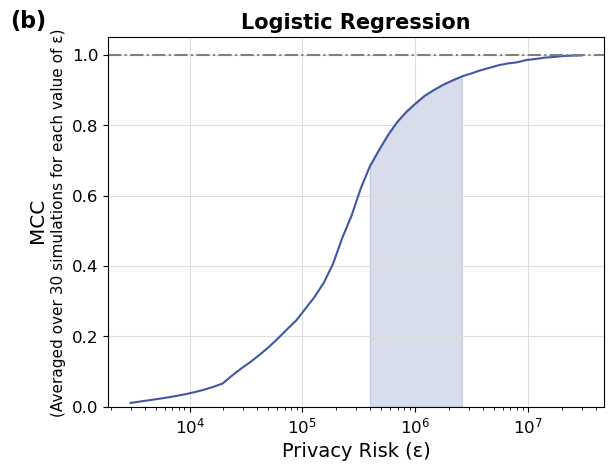

In [143]:
# Create the figure with the specified size
fig_lr1 = plt.figure(figsize=(6.4, 4.8))

# Plot the main line
plt.semilogx(epsilons[:-1], avg_DPlr_mcc, color='#40589F', label="Differentially Private") # :-1 when infinity is included
plt.axhline(y=lr_noDP_mcc_list.mean(), color='grey', linestyle='-.', label="Non-Private")

# Define the bounds for x values
x_lower, x_upper = 356000, 2810000

# Find the indices where epsilons fall within the specified x range
x_mask = (epsilons[:-1] >= x_lower) & (epsilons[:-1] <= x_upper)

# Fill the area under the curve between 0 and the curve values
plt.fill_between(epsilons[:-1][x_mask], 0, avg_DPlr_mcc[x_mask], 
                 where=(avg_DPlr_mcc[x_mask] >= 0), 
                 color='#40589F', alpha=0.2, label="Highlighted Range")


plt.title("Logistic Regression", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_lr1.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Fix y-axis limits
plt.ylim(0, 1.05)  # Set limits to prevent stretching below 0.4

# Add a separate text elements
plt.figtext(0, 0.9, "(b)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('../figures/LR-Graph4.png', dpi=400, bbox_inches='tight')
plt.show()

### 4: Exploring the impact of imbalance

In [123]:
lr_runtime.loc['Start Time', 'Compare'] = time.time()

# Define data files and parameters
sampledTrain = ['fraudTrain_1%.csv', 'fraudTrain_2%.csv', 'fraudTrain_3%.csv', 
              'fraudTrain_4%.csv', 'fraudTrain_5%.csv', 'fraudTrain_10%.csv',
               'fraudTrain_15%.csv', 'fraudTrain_20%.csv']
colNames = ['1%', '2%', '3%', '4%', '5%', '10%', '15%', '20%']

epsilons = np.logspace(np.log10(3e3), np.log10(3e7), 50)
epsilons = np.append(epsilons, np.inf)
num_runs = 30

# Dictionaries to store the resulting dataframes
avg_DPlr_sampled_mcc_dict = {}
avg_lr_noDP_sampled_mcc_dict = {}

# Loop through the training and test files
for file, name in tqdm(zip(sampledTrain, colNames), total=len(sampledTrain)):

    # Load the datasets
    sampled_data = pd.read_csv(f'../datasets/{file}')  # Test established previously
    X_train_sampled = sampled_data.drop(['is_fraud'], axis=1).values # not sure .values is needed
    y_train_sampled = sampled_data['is_fraud']

    # Scale to the existing schema
    X_train_sampled = scaler.transform(X_train_sampled)

    # Empty list for the loop to fill
    dplr_mcc_sampled_rows = []
    
    for run in tqdm(range(num_runs), desc=f"Runs for {name}"):
        for epsilon in epsilons:
            DPlr_sampled = dp.models.LogisticRegression(epsilon=epsilon, random_state=(42 + run), max_iter=150, data_norm=data_norm)
            DPlr_sampled.fit(X_train_sampled, y_train_sampled)
            y_pred_DPlr_sampled = DPlr_sampled.predict(X_test) # Test established previously
            dplr_mcc_sampled_rows.append( 
                {
                    "epsilon": epsilon,
                    "run": run,
                    "mcc": matthews_corrcoef(y_test, y_pred_DPlr_sampled), 
                } 
            ) # Test established previously

    # Convert data to dataframe
    dplr_mcc_sampled_df = pd.DataFrame(dplr_mcc_sampled_rows)
    #dplr_mcc_sampled_df = pd.DataFrame(dplr_mcc_sampled_rows).set_index("epsilon")

    # Compute the average MCC across all runs
    grouped_mcc_sampled = dplr_mcc_sampled_df.groupby("epsilon")["mcc"].mean()

    # Separate the non-private MCC value (epsilon = infinity)
    avg_lr_noDP_sampled_mcc = grouped_mcc_sampled[np.inf]
    avg_DPlr_sampled_mcc = grouped_mcc_sampled.iloc[:-1]
   
    # Store the resulting dataframe in the dictionary
    avg_lr_noDP_sampled_mcc_dict[name] = avg_lr_noDP_sampled_mcc
    avg_DPlr_sampled_mcc_dict[name] = avg_DPlr_sampled_mcc

# Access the resulting dataframes using avg_DPlr_mcc_dict
print('Complete')

100%|███████████████████████████████████| 8/8 [5:23:48<00:00, 2428.61s/it]

Complete


In [124]:
# Add previously calculated baseline runs to the dictionaries
avg_lr_noDP_sampled_mcc_dict['Baseline'] = lr_noDP_mcc_list.mean()
avg_DPlr_sampled_mcc_dict['Baseline'] = avg_DPlr_mcc

#print(avg_lr_noDP_sampled_mcc_dict)
#print(avg_DPlr_sampled_mcc_dict)

lr_runtime.loc['End Time', 'Compare'] = time.time()

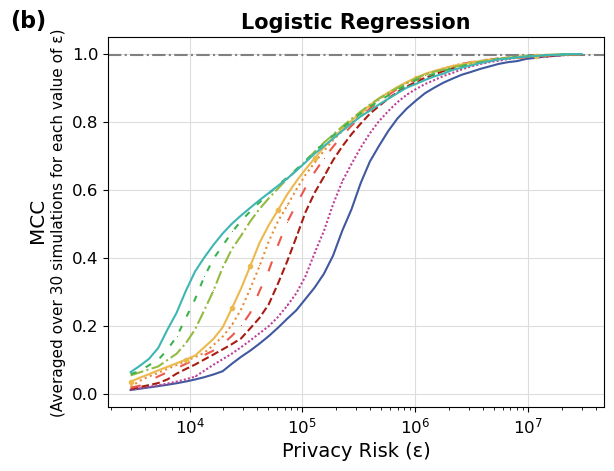

In [125]:
# Create the figure with the specified size
fig_lr2 = plt.figure(figsize=(6.4, 4.8))

# Plot the non-DP sampled values
plt.axhline(y=avg_lr_noDP_sampled_mcc_dict['Baseline'], color='grey', linestyle='-.', label="Non-DP Baseline")

lr_MCC_min = min(avg_lr_noDP_sampled_mcc_dict.values())
lr_MCC_max = max(avg_lr_noDP_sampled_mcc_dict.values())
plt.axhspan(lr_MCC_max, lr_MCC_min, facecolor='silver', alpha=0.2, label="Non-Private sampled Range")

plt.semilogx(epsilons[:-1], avg_DPlr_sampled_mcc_dict['Baseline'], color='#40589F', label="Baseline (π < 1%}")

# Add the sampled lines for comparison
colors = ['#BE4196', '#A91C11', '#EB594D', '#E88C38', '#EBB94D', '#94BA42', '#3BB450', '#3EB6B4']
labels = ['π = 1%', 'π = 2%', 'π = 3%', 'π = 4%', 'π = 5%', 'π = 10%', 'π = 15%', 'π = 20%']
widths = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5 ]
styles = [(0, (1, 1)), '--', (0, (5, 8)), ':', '-', '-.', (0, (3, 5)), '-' ]
markers= [",", ",", ",", ",", ".", ",", ",", ","] 

for name, color, label, width, style, marker in zip(colNames[:], colors, labels, widths, styles, markers):
    plt.semilogx(epsilons[:-1], avg_DPlr_sampled_mcc_dict[name], color=color, label=label, linewidth=width, 
                 linestyle=style, marker=marker, markevery=.1)

plt.title("Logistic Regression", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_lr2.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a separate text elements
plt.figtext(0, 0.9, "(b)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('../figures/LR-Graph5.png', dpi=600, bbox_inches='tight')
plt.show()

In [126]:
print(lr_MCC_min)
print(lr_MCC_max)

0.9981262439347174
0.9995318852157019


In [127]:
# Calculate Runtimes
lr_runtime.loc['Runtime'] = lr_runtime.loc['End Time'] - lr_runtime.loc['Start Time']

# Output Runtime data
lr_runtime

,Setup,Validate,Baseline,Compare
Start Time,1731014061.237031,1731014062.74263,1731018548.016182,1731020700.972678
End Time,1731014062.73004,1731014104.671917,1731020700.51331,1731040129.889805
Runtime,1.493009,41.929287,2152.497128,19428.917127


In [129]:
print(avg_DPlr_sampled_mcc_dict['20%'])

epsilon
3.000000e+03    0.063789
3.620378e+03    0.082227
4.369045e+03    0.102916
5.272532e+03    0.134692
6.362853e+03    0.188638
7.678644e+03    0.238553
9.266531e+03    0.302702
1.118278e+04    0.359617
1.349530e+04    0.400749
1.628603e+04    0.437984
1.965386e+04    0.471395
2.371813e+04    0.500172
2.862286e+04    0.524451
3.454186e+04    0.547265
4.168486e+04    0.569474
5.030499e+04    0.590338
6.070769e+04    0.611508
7.326159e+04    0.632793
8.841155e+04    0.656112
1.066944e+05    0.680981
1.287580e+05    0.706581
1.553842e+05    0.728230
1.875166e+05    0.750608
2.262936e+05    0.773506
2.730895e+05    0.795180
3.295623e+05    0.815858
3.977134e+05    0.832990
4.799576e+05    0.851190
5.792093e+05    0.867803
6.989855e+05    0.884428
8.435306e+05    0.900477
1.017967e+06    0.911431
1.228475e+06    0.923136
1.482514e+06    0.933696
1.789087e+06    0.941955
2.159057e+06    0.952632
2.605534e+06    0.959478
3.144339e+06    0.966049
3.794566e+06    0.973029
4.579254e+06    0

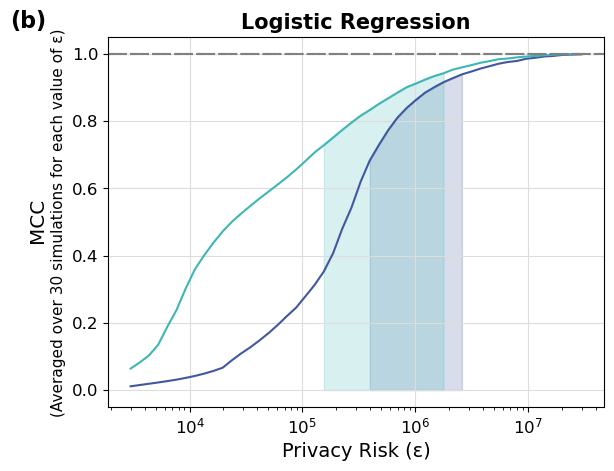

In [142]:
# Baseline to 20% imbalance comparison

# Create the figure with the specified size
fig_lr3 = plt.figure(figsize=(6.4, 4.8))

# Plot the results
plt.semilogx(epsilons[:-1], avg_DPlr_mcc, color='#40589F', label="Baseline (π < 1%)") 
plt.semilogx(epsilons[:-1], avg_DPlr_sampled_mcc_dict['20%'], color='#3EB6B4', label="π = 20%") 

# Define the bounds for x values
x_lower_lrb, x_upper_lrb = 356000, 2810000
x_lower_lr20, x_upper_lr20 = 129000, 1790000

# Find the indices where epsilons fall within the specified x range
x_mask_lrb = (epsilons[:-1] >= x_lower_lrb) & (epsilons[:-1] <= x_upper_lrb)
x_mask_lr20 = (epsilons[:-1] >= x_lower_lr20) & (epsilons[:-1] <= x_upper_lr20)

# Fill the area under the curve between 0 and the curve values
plt.fill_between(epsilons[:-1][x_mask_lrb], 0, avg_DPlr_mcc[x_mask_lrb], 
                 where=(avg_DPlr_mcc[x_mask_lrb] >= 0), 
                 color='#40589F', alpha=0.2, label="Highlighted Range")

plt.fill_between(epsilons[:-1][x_mask_lr20], 0, avg_DPlr_sampled_mcc_dict['20%'][x_mask_lr20], 
                 where=(avg_DPlr_sampled_mcc_dict['20%'][x_mask_lr20] >= 0), 
                 color='#3eb6B4', alpha=0.2, label="Highlighted Range")

# Use list comprehension to plot multiple horizontal lines
[plt.axhline(y=y, color=color, linestyle=style, label=label) for y, color, style, label in zip(
    [lr_noDP_mcc_list.mean(), avg_lr_noDP_sampled_mcc_dict['20%']],
    ['grey', 'grey'],
    ['-.', '--'],
    ["Non-Private Baseline", "Non-Private 20% sampled"])
]

plt.title("Logistic Regression", fontweight='bold', fontsize=15)
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.xlabel("Privacy Risk (ε)", fontsize=14)
plt.ylabel("(Averaged over 30 simulations for each value of ε)", fontsize=11)
fig_lr3.figure.supylabel("MCC", fontsize="x-large", x=0)

# Set font size for tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a separate text elements
plt.figtext(0, 0.9, "(b)", ha="center", fontsize=16, fontweight='bold')

# Save and show the plot
plt.savefig('../figures/LR-Graph6.png', dpi=800, bbox_inches='tight') 
plt.show()